<a href="https://colab.research.google.com/github/skywalker0803r/AlphaCoin/blob/main/%E7%AC%AC%E4%B8%80%E7%AB%A0(%E4%BD%95%E8%AC%82%E7%AD%96%E7%95%A5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from abc import ABC, abstractmethod
import pandas as pd

class BaseStrategy(ABC):
    def __init__(self, data: pd.DataFrame):
        """
        :param data: 包含收盤價等欄位的歷史資料 DataFrame
        """
        self.data = data
        self.signals = pd.Series(index=self.data.index, dtype="object")

    @abstractmethod
    def generate_signals(self):
        """
        子類別實作策略邏輯，填入 self.signals（'buy', 'sell', 'hold'）
        """
        pass

    def get_signals(self) -> pd.Series:
        return self.signals

class MACDStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, fast=12, slow=26, signal=9):
        super().__init__(data)
        self.fast = fast
        self.slow = slow
        self.signal_period = signal

    def generate_signals(self):
        close = self.data['close']
        ema_fast = close.ewm(span=self.fast, adjust=False).mean()
        ema_slow = close.ewm(span=self.slow, adjust=False).mean()
        macd = ema_fast - ema_slow
        signal_line = macd.ewm(span=self.signal_period, adjust=False).mean()

        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[macd > signal_line] = 'buy'
        self.signals[macd < signal_line] = 'sell'
        self.signals[macd == signal_line] = 'hold'

class RSIStrategy(BaseStrategy):
    def __init__(self, data: pd.DataFrame, period=14, overbought=70, oversold=30):
        super().__init__(data)
        self.period = period
        self.overbought = overbought
        self.oversold = oversold

    def generate_signals(self):
        delta = self.data['close'].diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)

        avg_gain = gain.rolling(self.period).mean()
        avg_loss = loss.rolling(self.period).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))

        self.signals = pd.Series(index=self.data.index, dtype="object")
        self.signals[rsi < self.oversold] = 'buy'
        self.signals[rsi > self.overbought] = 'sell'
        self.signals[(rsi >= self.oversold) & (rsi <= self.overbought)] = 'hold'


import yfinance as yf
import datetime
import pandas as pd

# 下載多幣種也沒問題
df = yf.download("BTC-USD", start="2025-01-01", end=datetime.datetime.now())

# 通用欄位標準化
if isinstance(df.columns, pd.MultiIndex):
    df.columns = ['_'.join([str(c).lower() for c in col]) for col in df.columns]
    tickers = set(col.split('_')[-1] for col in df.columns)
    if len(tickers) == 1:
        ticker_suffix = list(tickers)[0]
        df.columns = [col.replace(f"_{ticker_suffix}", '') for col in df.columns]
else:
    df.columns = df.columns.str.lower()

# 檢查是否有 close
assert 'close' in df.columns, "找不到 close 欄位"

# 套用策略
strategy = MACDStrategy(df)
strategy.generate_signals()
strategy.get_signals()

/tmp/ipython-input-32-3366157369.py:69: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("BTC-USD", start="2025-01-01", end=datetime.datetime.now())
[*********************100%***********************]  1 of 1 completed


,0
Date,
2025-01-01,hold
2025-01-02,buy
2025-01-03,buy
2025-01-04,buy
2025-01-05,buy
...,...
2025-06-22,sell
2025-06-23,sell
2025-06-24,sell


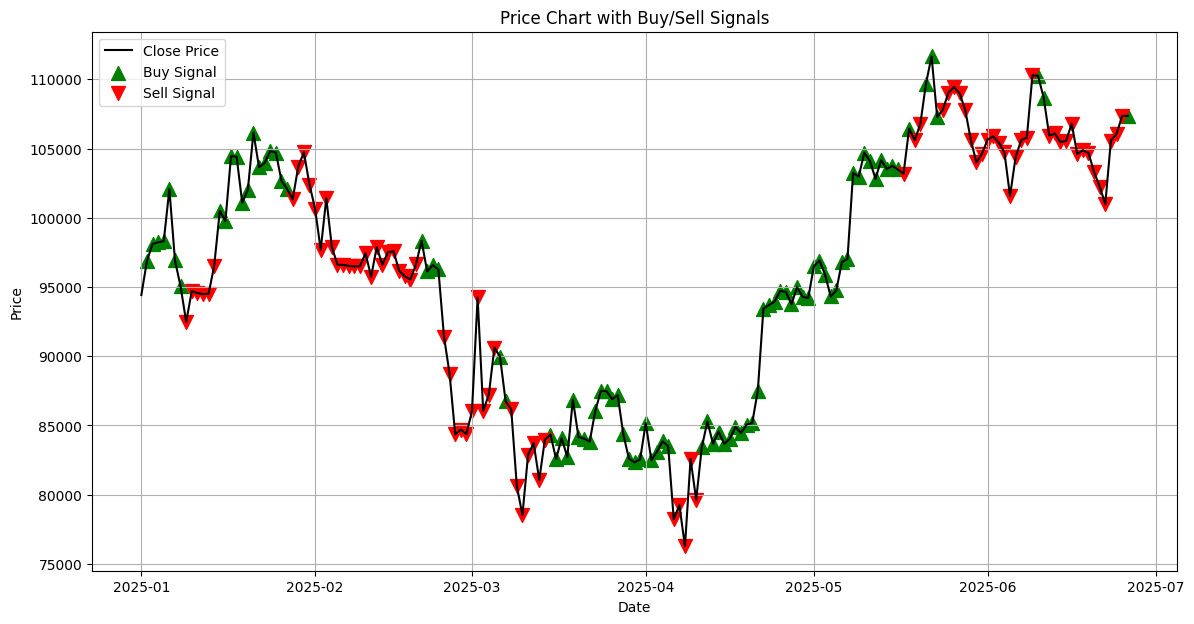

In [33]:
import matplotlib.pyplot as plt

signals = strategy.get_signals()
close = df['close']

plt.figure(figsize=(14, 7))
plt.plot(close.index, close, label='Close Price', color='black')

# 買點用綠色三角形標記
buy_signals = signals == 'buy'
plt.scatter(close.index[buy_signals], close[buy_signals], marker='^', color='green', label='Buy Signal', s=100)

# 賣點用紅色倒三角形標記
sell_signals = signals == 'sell'
plt.scatter(close.index[sell_signals], close[sell_signals], marker='v', color='red', label='Sell Signal', s=100)

plt.title('Price Chart with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()
